In [1]:
#Step 1
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from geopy.geocoders import Nominatim

In [2]:
#Step 2
# Read weather and demographic data from TSV files.
snowstorm_data = pd.read_csv("C:/Users/Anorm/Downloads/snowstorm_PA.tsv", sep='\t')
pa_cities_counties = pd.read_csv("C:/Users/Anorm/Downloads/PA_cities_counties.tsv", sep='\t')

# Read geospatial data (zipped shapefiles) into GeoDataFrames.
tl_us_counties = gpd.read_file("C:/Users/Anorm/Downloads/tl_2021_us_county.zip")
pa_municipalities = gpd.read_file("C:/Users/Anorm/Downloads/PaMunicipalities2022_01.zip")

In [3]:
#Step 3
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the Earth (in km).
    All arguments should be arrays or scalars of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def plot_with_labels(some_gdf, ax, name_col=None, field_col=None, **kwargs):
    """
    Plot a GeoDataFrame with an option to display feature names and color by a given field.
    """
    if field_col is None:
        some_gdf.plot(ax=ax, **kwargs)
    else:
        some_gdf.plot(column=field_col, ax=ax, legend=True, **kwargs)
    
    if name_col is not None:
        for idx, row in some_gdf.iterrows():
            ax.annotate(text=row[name_col], xy=row['coords'],
                        horizontalalignment='center')

def calc_overall_centroid(some_gdf):
    """
    Calculate the overall centroid weighted by area.
    Assumes the GeoDataFrame has 'area' and 'coords' columns.
    """
    sum_x = sum_y = sum_area = 0.0
    for idx, row in some_gdf.iterrows():
        coord_x, coord_y = row['coords']
        sum_x += coord_x * row['area']
        sum_y += coord_y * row['area']
        sum_area += row['area']
    return sum_x / sum_area, sum_y / sum_area

def add_area_and_label_coords(some_gdf):
    """
    Calculates the area for each geometry and determines a representative point
    for labeling. Returns the modified GeoDataFrame.
    """
    some_gdf['area'] = some_gdf.area
    some_gdf['coords'] = some_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    some_gdf['coords'] = [coords[0] for coords in some_gdf['coords']]
    return some_gdf

In [4]:
#Step 4
pa_counties = tl_us_counties[tl_us_counties['STATEFP'] == '42']
pa_counties = add_area_and_label_coords(pa_counties)
centroid_x, centroid_y = calc_overall_centroid(pa_counties)
ortho = CRS.from_proj4(f"+proj=ortho +lat_0={centroid_y} +lon_0={centroid_x} +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")
ortho_gdf = pa_counties.to_crs(ortho)
ortho_gdf = add_area_and_label_coords(ortho_gdf)

C:\Users\Anorm\AppData\Local\Temp\ipykernel_26240\1856396571.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area
c:\Users\Anorm\anaconda3\envs\machinelearning\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Anorm\anaconda3\envs\machinelearning\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [5]:
#Step 5
# Merge snowfall data with city-county mapping on 'Location' (city name)
merged_df = snowstorm_data.merge(pa_cities_counties, left_on='Location', right_on='Name', how='left')

# Initialize geocoder
geolocator = Nominatim(user_agent="pa_snowfall_analysis")

# Function to fetch county name
def get_county(city):
    try:
        location = geolocator.geocode(f"{city}, Pennsylvania, US", timeout=10)
        if location:
            address_parts = location.address.split(", ")
            county = next((part for part in address_parts if "County" in part), None)
            if county:
                return county.split()[0]  # Extract only the first word (county name)
    except Exception as e:
        print(f"Geocoding failed for {city}: {e}")
    return None  # Return None if not found

# Apply function to missing counties
merged_df['County'] = merged_df['County'].fillna(merged_df['Location'].apply(get_county))

# Check how many are still missing
print("Remaining missing county values:", merged_df['County'].isna().sum())



Remaining missing county values: 1


In [6]:
# Select only the needed columns: 'County' and 'Expected Snowfall'
county_snowfall = merged_df[['County', 'Expected Snowfall']].dropna()

# Group by county and compute the average snowfall
county_avg_snowfall = county_snowfall.groupby('County', as_index=False).mean()

# Display results
print(county_avg_snowfall.head())


      County  Expected Snowfall
0  Allegheny          11.571429
1  Armstrong           9.500000
2     Beaver          12.400000
3     Butler          12.200000
4    Clarion          11.500000


In [7]:
#Step 6
# Ensure county names are the same in both dataframes
county_avg_snowfall.rename(columns={'County': 'NAME'}, inplace=True)

# Merge the snowfall data with the ortho_gdf GeoDataFrame
ortho_gdf = ortho_gdf.merge(county_avg_snowfall, on="NAME", how="left")

# Display the first few rows to verify
print(ortho_gdf[['NAME', 'Expected Snowfall']].head())


      NAME  Expected Snowfall
0   Beaver               12.4
1   Forest               12.0
2    Tioga                NaN
3  Dauphin                NaN
4    Wayne                NaN


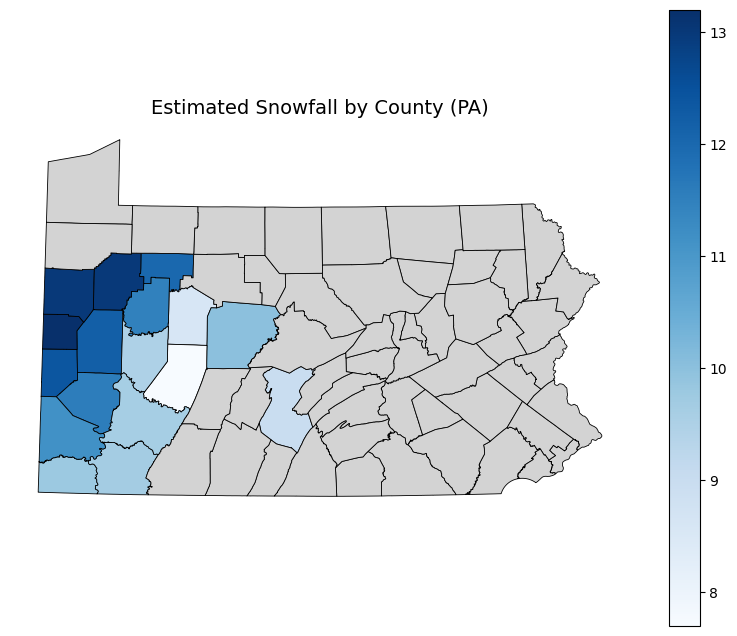

In [8]:
#Step 7
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the snowfall data using 'Blues' colormap
ortho_gdf.plot(column='Expected Snowfall',
               cmap='Blues',
               linewidth=0.6,
               edgecolor='black',
               missing_kwds={"color": "lightgray", "label": "No Data"},
               legend=True,
               ax=ax)

# Add title and adjust layout
ax.set_title("Estimated Snowfall by County (PA)", fontsize=14)
ax.axis("off")  # Hide axis for a cleaner look

# Show the plot
plt.show()


In [9]:
#Step 8
# Load the PA municipalities shapefile
pa_municipalities = gpd.read_file("C:/Users/Anorm/Downloads/PaMunicipalities2022_01.zip")

# Check the original CRS
print("Original CRS:", pa_municipalities.crs)

# Define the Platte Carree projection (EPSG:4326)
platte_carree = CRS.from_epsg(4326)

# Convert to Orthographic Projection (same as ortho_gdf)
pa_municipalities_ortho = pa_municipalities.to_crs(ortho)

# Convert to Platte Carree Projection (EPSG:4326)
pa_municipalities_pc = pa_municipalities.to_crs(platte_carree)

# Add area and label coordinates
pa_municipalities_ortho = add_area_and_label_coords(pa_municipalities_ortho)
pa_municipalities_pc = add_area_and_label_coords(pa_municipalities_pc)

# Display CRS information for verification
print("Orthographic CRS:", pa_municipalities_ortho.crs)
print("Platte Carree CRS:", pa_municipalities_pc.crs)


Original CRS: EPSG:3857
Orthographic CRS: +proj=ortho +lat_0=40.900430189750736 +lon_0=-77.84058346055701 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs +type=crs
Platte Carree CRS: EPSG:4326


C:\Users\Anorm\AppData\Local\Temp\ipykernel_26240\1856396571.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  some_gdf['area'] = some_gdf.area


Travel Cities Found:      MUNICIPAL1                                    coords
0    PITTSBURGH  (-180291.4221698459, -50021.98503809112)
1      SCRANTON   (181869.89535306327, 58367.90517060508)
2     ALLENTOWN  (199291.1721502056, -31442.249235449937)
3  PHILADELPHIA  (230197.84440388167, -96196.28907382858)
4    HARRISBURG   (79996.05578118909, -68320.45161914709)
5    PITTSBURGH  (-180291.4221698459, -50021.98503809112)


C:\Users\Anorm\AppData\Local\Temp\ipykernel_26240\3687132525.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")
C:\Users\Anorm\AppData\Local\Temp\ipykernel_26240\3687132525.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


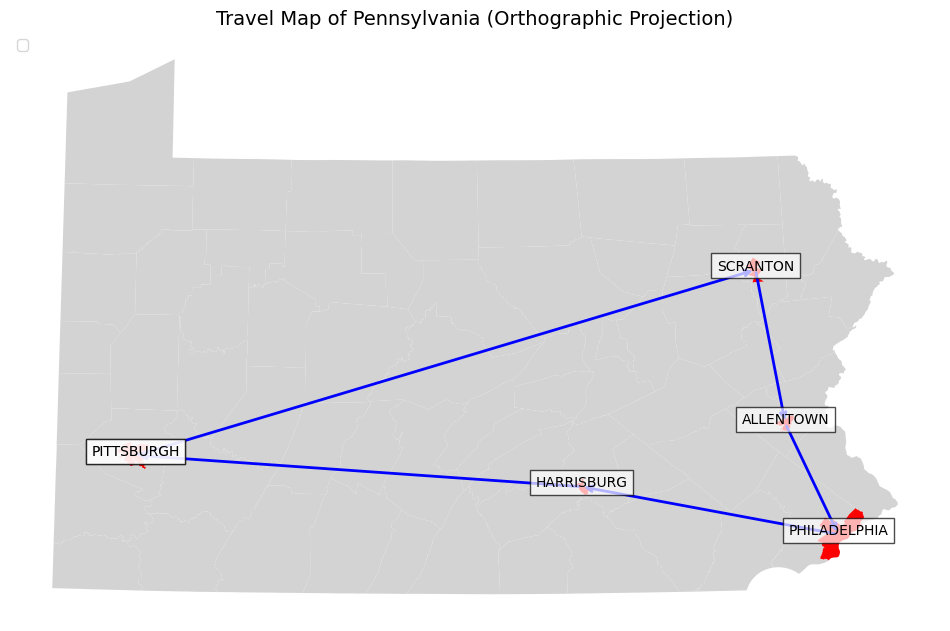

In [10]:
#Step 9
# Define the cities for travel in the specified order
travel_cities = ["PITTSBURGH", "SCRANTON", "ALLENTOWN", "PHILADELPHIA", "HARRISBURG", "PITTSBURGH"]

# Filter the municipalities GeoDataFrame for these cities
travel_cities_gdf = pa_municipalities_ortho[pa_municipalities_ortho['MUNICIPAL1'].isin(travel_cities)]

# Ensure the cities are ordered correctly according to travel_cities
travel_cities_gdf = travel_cities_gdf.set_index('MUNICIPAL1').reindex(travel_cities).reset_index()

# Check if all cities were found and their coordinates
print("Travel Cities Found:", travel_cities_gdf[['MUNICIPAL1', 'coords']])

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the full PA geometry (counties) in light gray
ortho_gdf.plot(ax=ax, color="lightgray", edgecolor="none")

# Plot the travel cities on top of the map in red
travel_cities_gdf.plot(ax=ax, color="red", markersize=50, label="Travel Cities")

# Add arrows to represent travel steps (looping back to PITTSBURGH)
for i in range(len(travel_cities_gdf) - 1):
    start_coords = travel_cities_gdf.iloc[i]['coords']
    end_coords = travel_cities_gdf.iloc[i + 1]['coords']
    ax.annotate(
        "", xy=end_coords, xytext=start_coords,
        arrowprops=dict(arrowstyle="->", color="blue", lw=2)
    )

# Add labels for each city
for idx, row in travel_cities_gdf.iterrows():
    ax.text(row['coords'][0], row['coords'][1], row['MUNICIPAL1'], fontsize=10,
            ha='center', color='black', bbox=dict(facecolor='white', alpha=0.7))

# Add a title and legend
ax.set_title("Travel Map of Pennsylvania (Orthographic Projection)", fontsize=14)
ax.legend(loc="upper left")
ax.axis("off")  # Hide axis for a cleaner look

# Show the plot
plt.show()


In [11]:
#Step 10
# Calculate distances in the orthographic projection (straight-line distances)
total_distance_ortho = 0
for i in range(len(travel_cities_gdf) - 1):
    start_point = travel_cities_gdf.iloc[i]['geometry'].centroid
    end_point = travel_cities_gdf.iloc[i + 1]['geometry'].centroid
    distance = start_point.distance(end_point) / 1000  # Convert meters to kilometers
    total_distance_ortho += distance

print(f"Total straight-line travel distance (Orthographic Projection): {total_distance_ortho:} km")

# Convert to Plate Carrée projection (EPSG:4326)
travel_cities_pc = travel_cities_gdf.to_crs(epsg=4326)

# Calculate distances using haversine formula in Plate Carrée projection
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate Haversine distance between two points on Earth.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Radius of Earth in kilometers

total_distance_haversine = 0
for i in range(len(travel_cities_pc) - 1):
    start_coords = travel_cities_pc.iloc[i]['geometry'].centroid.coords[0]
    end_coords = travel_cities_pc.iloc[i + 1]['geometry'].centroid.coords[0]
    distance = haversine(start_coords[0], start_coords[1], end_coords[0], end_coords[1])
    total_distance_haversine += distance

print(f"Total travel distance (Haversine Formula): {total_distance_haversine:} km")

# Explanation of Differences
print("\nExplanation of Differences:")
print("The orthographic projection calculates straight-line distances on a flat plane.")
print("The Haversine formula calculates great-circle distances on a sphere thus resulting in a difference over longer distances and places where the earth is especially curved.")

Total straight-line travel distance (Orthographic Projection): 954.7473631081168 km
Total travel distance (Haversine Formula): 954.9156229551425 km

Explanation of Differences:
The orthographic projection calculates straight-line distances on a flat plane.
The Haversine formula calculates great-circle distances on a sphere thus resulting in a difference over longer distances and places where the earth is especially curved.
